In [1]:
include("prepare.jl")

In [14]:
total_steps = 10000

d0 = 10.
β0 = - π / 2 * (3/4)

data = []

car = Car(state=State(x=-1., y=-11., ψ = 0., ẋ = 1., ẏ = 0., ψ̇ = 0.),tyre=Tyre(B=5, C=2, D=0.3))
β_controller = PID(Kp=0.8, Ki=0.001, Kd=200, sign=1)
d_controller = PID(Kp=30, Ki=0.001, Kd=5, sign=-1)
#R_controller = PID(Kp=100, Ki=0.8, Kd=100, sign=-1) 无前馈最佳参数
est = make_radius_estimator(10)
est_circles = []
est_circle = update!(est, car.state.x, car.state.y)

β0s = []
d0s = []
ds = []
inputs = []

ω0 = 30
ω_ff = 0

C1x = 0.
C1y = 0.
C2x = 20.
C2y = 0.

texture = "snow"

for i in 1:total_steps
    Cx = C1x
    Cy = C1y

    s = car.state

    if i < total_steps / 3
        β0 = - π / 2 * (3/4)
    elseif i > total_steps / 3 && abs(round_angle(s.ψ) -(-85/180*π))< 0.01
        β0 = + π / 2 * (3/4)
    end

    est_circle = update!(est, car.state.x, car.state.y)
    R = est_circle.r

    
    β = atan(s.ẏ, s.ẋ) - s.ψ
    err = round_angle(β - β0)
    δ = clamp(control!(β_controller, err), -π / 8, π / 8)

    d = sqrt((s.x-Cx)^2+(s.y-Cy)^2)
    
    if i % 10 == 0 && i > 1000
        err = d - d0
        ω0 = clamp(ω_ff + control!(d_controller, err), 15, 45)
    end
    ω = 20
    # apply control and save data
    u = Input(δ, ω, ω)
    data_point = DriftData(s, u, compute_extended_state(s, u, car.body, car.tyre), R)
    step!(car, u, dt=0.01)
    push!(data,  data_point)
    push!(β0s,  β0)
    push!(d0s,  d0)
    push!(ds,  d)
end

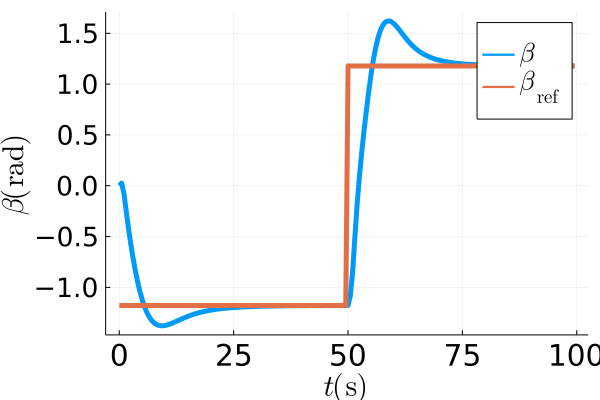

In [15]:
t1 = 1
t2 = length(data)
rate = 50

using Plots
using LaTeXStrings
using PGFPlotsX
gr()
p1 = plot(0.01*(t1:rate:t2),[p.es.β for p in data[t1:rate:t2]], label=L"$\beta$", xlabel=L"$t \mathrm{(s)}$",ylabel=L"$\beta \mathrm{(rad)}$", xtickfontsize=18,ytickfontsize=18,xguidefontsize=20,yguidefontsize=20,legendfontsize=20,width=5)
plot!(p1, 0.01*(t1:rate:t2),β0s[t1:rate:t2], label=L"$\beta_{\mathrm{ref}}$",xtickfontsize=20,ytickfontsize=18,xguidefontsize=20,yguidefontsize=20,legendfontsize=18,width=5)
plot(p1)
#savefig(p1, "tikz/8-drift/8-drift-p1.pdf")
#savefig(p1, "tikz/fix-center/fix-center-p1.tikz")

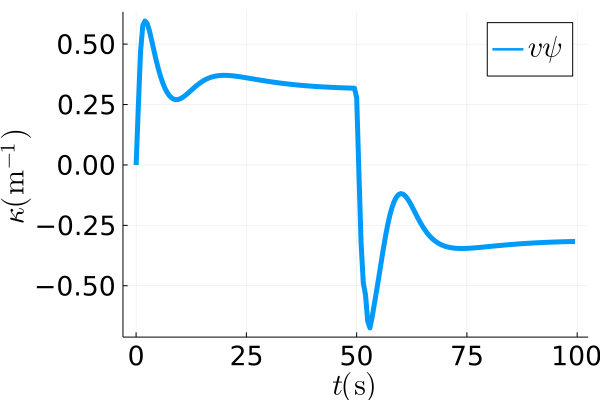

In [16]:
p5 = plot(0.01*(t1:rate:t2), [p.s.ψ̇  for p in data[t1:rate:t2]], label=L"$v \psi$",xlabel=L"$t \mathrm{(s)}$", ylabel=L"$\kappa \mathrm{(m^{-1})}$",xtickfontsize=18,ytickfontsize=18,xguidefontsize=20,yguidefontsize=20,legendfontsize=20,width=5)
plot(p5)

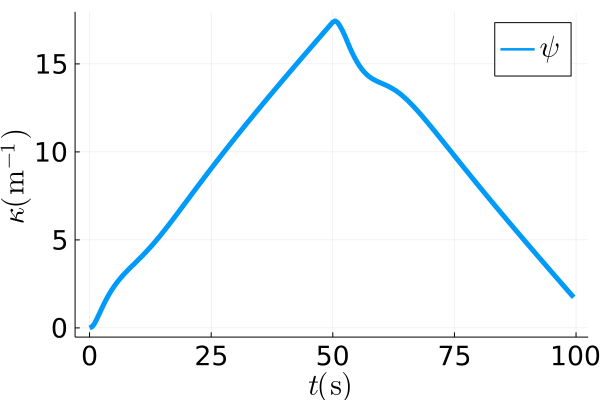

In [17]:
p6 = plot(0.01*(t1:rate:t2), [p.s.ψ for p in data[t1:rate:t2]], label=L"$ \psi$",xlabel=L"$t \mathrm{(s)}$", ylabel=L"$\kappa \mathrm{(m^{-1})}$",xtickfontsize=18,ytickfontsize=18,xguidefontsize=20,yguidefontsize=20,legendfontsize=20,width=5)
plot(p6)

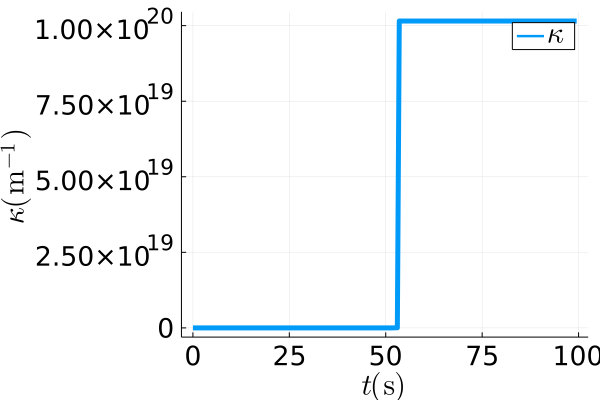

In [18]:
p2 = plot(0.01*(t1:rate:t2), [p.R for p in data[t1:rate:t2]], label=L"$\kappa$",xlabel=L"$t \mathrm{(s)}$", ylabel=L"$\kappa \mathrm{(m^{-1})}$",xtickfontsize=18,ytickfontsize=18,xguidefontsize=20,yguidefontsize=20,legendfontsize=20,width=5)
plot(p2)
#savefig(p2, "tikz/8-drift/8-drift-p2.pdf")
#savefig(p2, "tikz/fix-center/fix-center-p2.tikz")

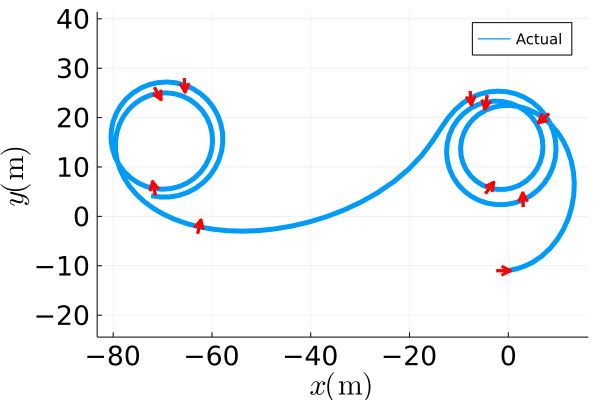

In [19]:
p3 = plot([p.s.x for p in data[t1:rate:t2]], [p.s.y for p in data[t1:rate:t2]], aspect_ratio=:equal, label="Actual", xlabel=L"$x \mathrm{(m)}$",ylabel=L"$y \mathrm{(m)}$",xtickfontsize=18,ytickfontsize=18,xguidefontsize=20,yguidefontsize=20,legendfontsize=10,width=5)

lF, lR = car.body.lF, car.body.lR
for p in data[t1:Int(t2 / 10):t2]
    s = p.s
    xF, yF = s.x + lF * cos(s.ψ), s.y + lF * sin(s.ψ)
    xR, yR = s.x - lR * cos(s.ψ), s.y - lR * sin(s.ψ)
    plot!(p3, [xR, xF], [yR, yF], color=:red, arrow=true, label="", width=3)
end
plot(p3)
#savefig(p3, "tikz/8-drift/8-drift-p3.pdf")
#savefig(p3, "tikz/fix-center/fix-center-p3.tikz")